Instruction:   
To run the final prediction results and calculate the MSE on the test set, you can directly skip to the last part of the code, the "6 Test Error" section, and run it.

# DATA

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import numpy as np

from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')

In [75]:
data_CPI = pd.read_csv('CPI_train.csv')

data_CPI['Quarter'] = pd.to_datetime(data_CPI['Quarter'], format='%Y-%m')

data_CPI.head()

,Quarter,CPI
0,1990-03-01,50.3
1,1990-06-01,51.7
2,1990-09-01,51.3
3,1990-12-01,51.8
4,1991-03-01,52.9


In [76]:
duplicates = data_CPI.duplicated().sum()
duplicates

0

In [77]:
missing_values = data_CPI.isnull().sum()
missing_values

Quarter    0
CPI        0
dtype: int64

In [78]:
description = data_CPI.describe()
description

,Quarter,CPI
count,132,132.000000
mean,2006-07-16 20:54:32.727272704,83.634091
min,1990-03-01 00:00:00,50.300000
25%,1998-05-09 00:00:00,62.075000
50%,2006-07-17 00:00:00,85.650000
75%,2014-09-23 18:00:00,103.800000
max,2022-12-01 00:00:00,125.600000
std,NaN,21.548397


In [79]:
data_CPI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Quarter  132 non-null    datetime64[ns]
 1   CPI      132 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 KB


In [80]:
data_CR = pd.read_excel('cashrate_data.xlsx', sheet_name=None)
historical_data = data_CR['Historical']
outlook_data = data_CR['Outlook']

In [81]:
print("Historical Data Columns:", historical_data.columns)
print(historical_data.head())
print("\nOutlook Data Columns:", outlook_data.columns)
print(outlook_data.head())

Historical Data Columns: Index(['Date', 'Cashrate'], dtype='object')
        Date  Cashrate
0 2011-01-04      4.75
1 2011-01-05      4.75
2 2011-01-06      4.75
3 2011-01-07      4.75
4 2011-01-10      4.75

Outlook Data Columns: Index([2023-01-01 00:00:00, 3.1], dtype='object')
  2023-01-01 00:00:00   3.1
0          2023-02-01  3.10
1          2023-03-01  3.35
2          2023-04-01  3.60
3          2023-05-01  3.60
4          2023-06-01  3.85


In [82]:
outlook_data.columns = ['Date','Cashrate']
outlook_data.head()

,Date,Cashrate
0,2023-02-01,3.10
1,2023-03-01,3.35
2,2023-04-01,3.60
3,2023-05-01,3.60
4,2023-06-01,3.85


In [83]:
historical_data['Date'] = pd.to_datetime(historical_data['Date'])
outlook_data['Date'] = pd.to_datetime(outlook_data['Date'])

In [84]:
duplicates = historical_data.duplicated().sum()
duplicates

0

In [85]:
missing_values = historical_data.isnull().sum()
missing_values

Date        0
Cashrate    0
dtype: int64

In [86]:
print(historical_data.head())
print(outlook_data.head())

        Date  Cashrate
0 2011-01-04      4.75
1 2011-01-05      4.75
2 2011-01-06      4.75
3 2011-01-07      4.75
4 2011-01-10      4.75
        Date  Cashrate
0 2023-02-01      3.10
1 2023-03-01      3.35
2 2023-04-01      3.60
3 2023-05-01      3.60
4 2023-06-01      3.85


# EDA

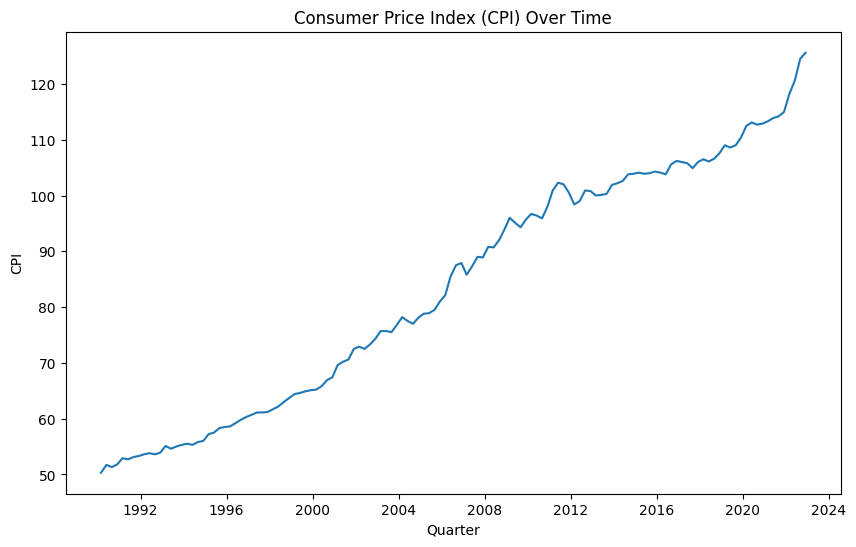

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(data_CPI['Quarter'], data_CPI['CPI'])
plt.title('Consumer Price Index (CPI) Over Time')
plt.xlabel('Quarter')
plt.ylabel('CPI')
# plt.grid(True)
plt.show()

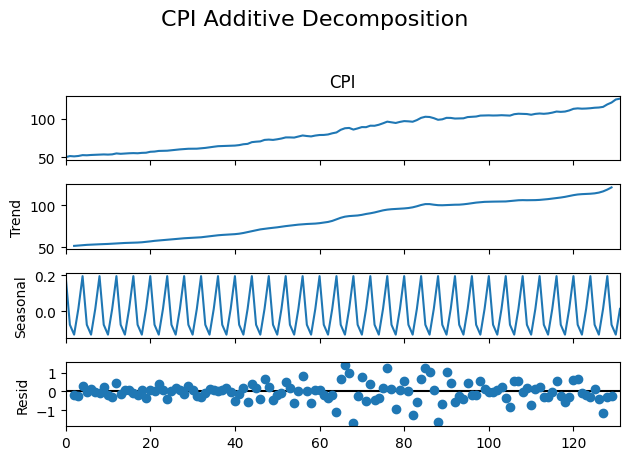

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decomppsiton
decompose_result = seasonal_decompose(data_CPI['CPI'], model='add', period=4)

# visualization
fig = decompose_result.plot()
fig.suptitle('CPI Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

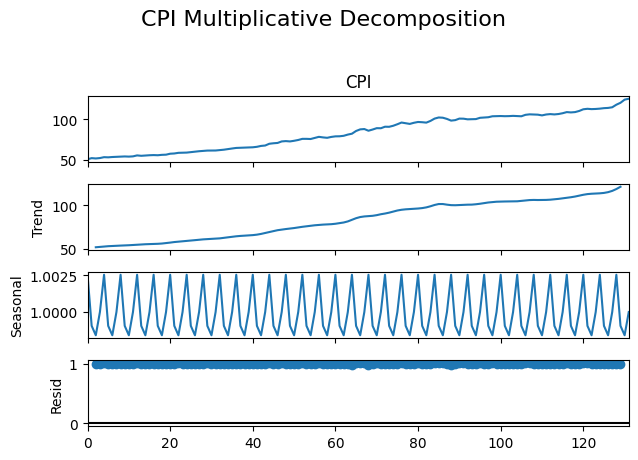

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decomppsiton
decompose_result = seasonal_decompose(data_CPI['CPI'], model='mul', period=4)

# visualization
fig = decompose_result.plot()
fig.suptitle('CPI Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

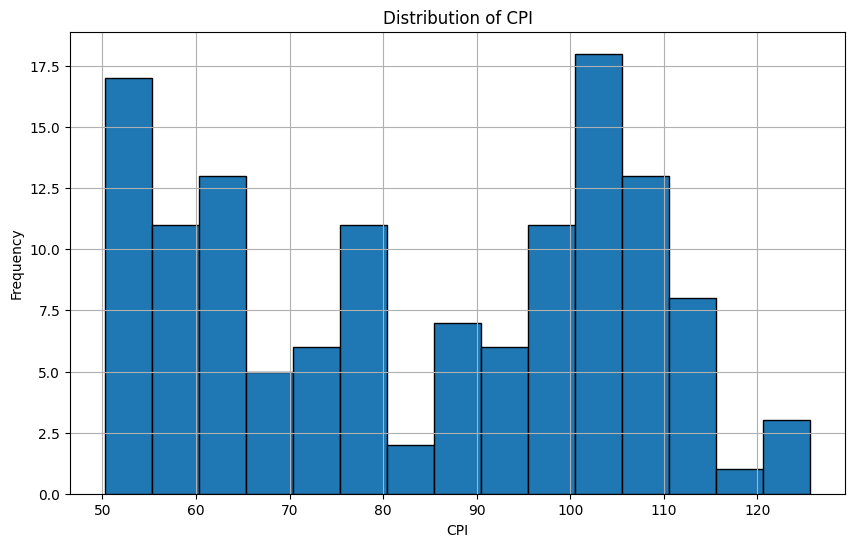

In [90]:
plt.figure(figsize=(10, 6))
plt.hist(data_CPI['CPI'], bins=15, edgecolor='black')
plt.title('Distribution of CPI')
plt.xlabel('CPI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

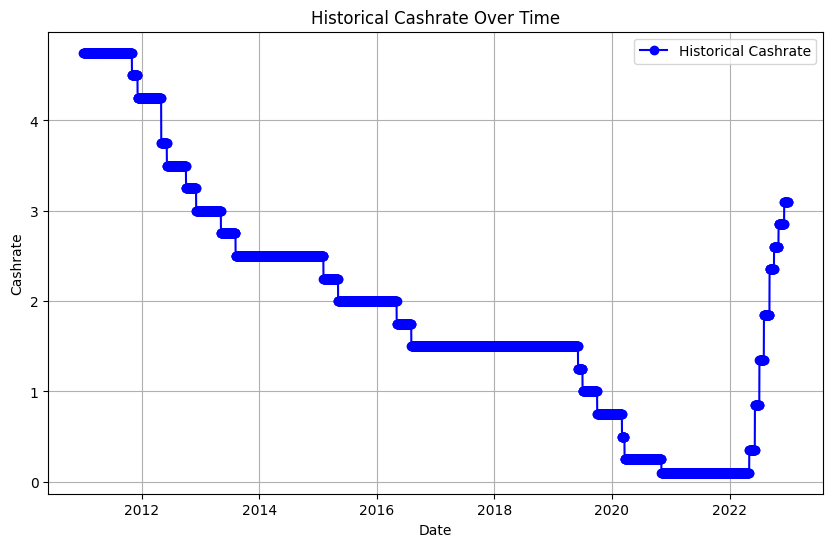

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(historical_data['Date'], historical_data['Cashrate'], marker='o', label='Historical Cashrate', color='b')
plt.title('Historical Cashrate Over Time')
plt.xlabel('Date')
plt.ylabel('Cashrate')
plt.grid(True)
plt.legend()
plt.show()

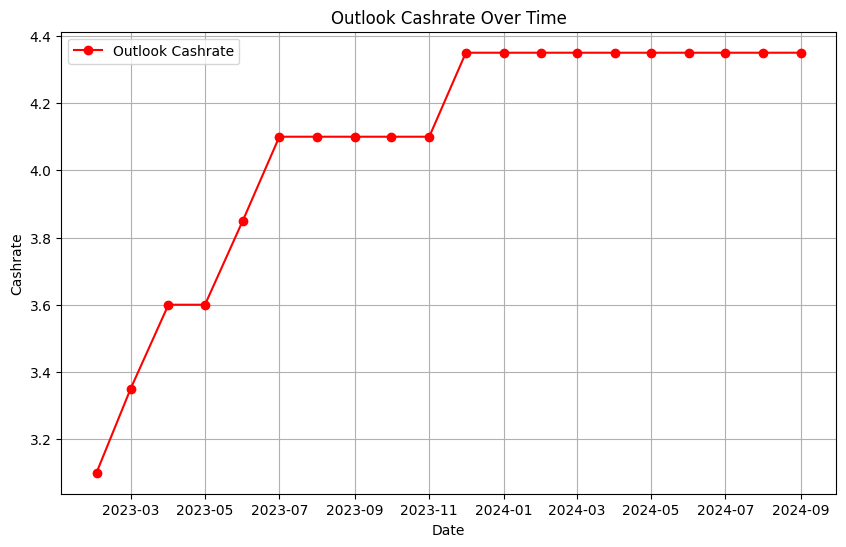

In [92]:
plt.figure(figsize=(10, 6))
plt.plot(outlook_data['Date'], outlook_data['Cashrate'], marker='o', label='Outlook Cashrate', color='r')
plt.title('Outlook Cashrate Over Time')
plt.xlabel('Date')
plt.ylabel('Cashrate')
plt.grid(True)
plt.legend()
plt.show()

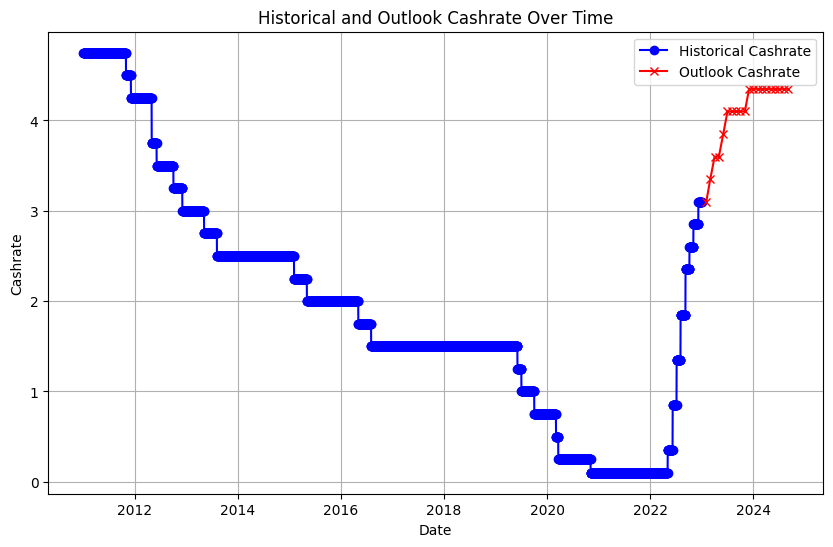

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(historical_data['Date'], historical_data['Cashrate'], marker='o', label='Historical Cashrate', color='b')
plt.plot(outlook_data['Date'], outlook_data['Cashrate'], marker='x', label='Outlook Cashrate', color='r')
plt.title('Historical and Outlook Cashrate Over Time')
plt.xlabel('Date')
plt.ylabel('Cashrate')
plt.legend()
plt.grid(True)
plt.show()

# Dataset Split and Feature Engineering

In [94]:
data_CPI.set_index('Quarter', inplace=True)

print(data_CPI.head())

             CPI
Quarter         
1990-03-01  50.3
1990-06-01  51.7
1990-09-01  51.3
1990-12-01  51.8
1991-03-01  52.9


In [95]:
data_CPI.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 1990-03-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     132 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [96]:
train_data = data_CPI[:-6]
test_data = data_CPI[-6:]
#train_data_hw = train_data[['CPI']].copy()

print("train data:", train_data.shape)
print("test data:", test_data.shape)

train data: (126, 1)
test data: (6, 1)


In [97]:
print(train_data.isnull().sum())

CPI    0
dtype: int64


In [98]:
print(test_data.isnull().sum())

CPI    0
dtype: int64


In [99]:
print(train_data.head())
print(test_data.head())

             CPI
Quarter         
1990-03-01  50.3
1990-06-01  51.7
1990-09-01  51.3
1990-12-01  51.8
1991-03-01  52.9
              CPI
Quarter          
2021-09-01  114.2
2021-12-01  115.0
2022-03-01  118.2
2022-06-01  120.6
2022-09-01  124.5


# Model Building

In [100]:
def plot_residual(residuals):
    # 1. residual plot
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label='Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.legend()
    plt.show()

    # 2. Residual Distribution Plot
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, bins=20)
    plt.title('Residual Distribution (Histogram)')
    plt.show()

    # 3. ACF/PACF Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plot_acf(residuals, lags=20,zero=False, ax=plt.gca())
    plt.title('ACF of Residuals')

    plt.subplot(122)
    plot_pacf(residuals, lags=20,zero=False, ax=plt.gca())
    plt.title('PACF of Residuals')
    plt.tight_layout()
    plt.show()

## Decomposition

**Step1: Moving Average**

In [101]:
np.random.seed(37)

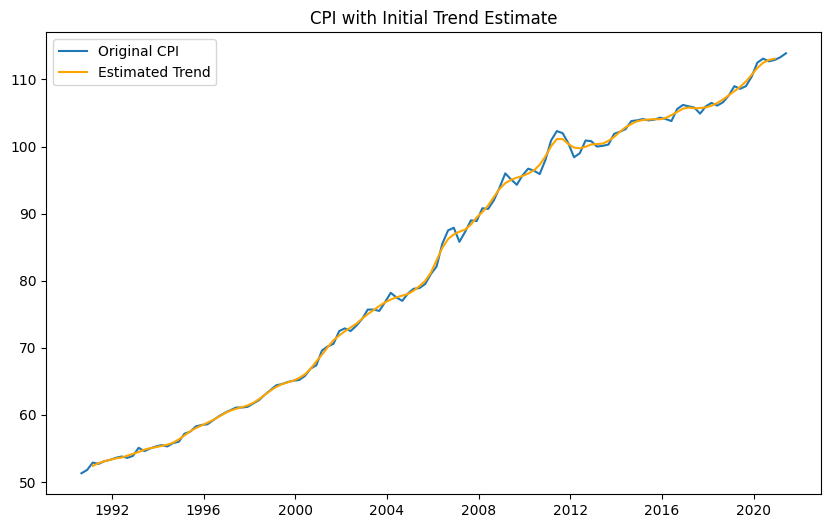

In [102]:
train_data_decomposition = train_data[2:]

# Set the moving average window size (quarters)
window_size = 4

# Perform moving average on the training set to obtain a initial trend estimate
trend_estimate = train_data_decomposition.rolling(window=window_size, center=True).mean().rolling(2, center=True).mean().shift(-1)

# Visualize the CPI and trend estimates of the training set, which are smoother than the original trend.
plt.figure(figsize=(10, 6))
plt.plot(train_data_decomposition.index, train_data_decomposition['CPI'], label='Original CPI')
plt.plot(train_data_decomposition.index, trend_estimate, label='Estimated Trend', color='orange')
plt.legend()
plt.title('CPI with Initial Trend Estimate')
plt.savefig('cpi_trend_estimate_Decomposition.png', dpi=300, bbox_inches='tight')
plt.show()


In [103]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [104]:
trend_estimate

,CPI
Quarter,
1990-09-01,NaN
1990-12-01,NaN
1991-03-01,52.4000
1991-06-01,52.8125
1991-09-01,53.0875
1991-12-01,53.3125
1992-03-01,53.5125
1992-06-01,53.6500
1992-09-01,53.9125


**Step2: De-trend**

The variance is relatively stable, with no obvious trend of increasing over time. Therefore, it may be more appropriate to use an additive model for trend decomposition.

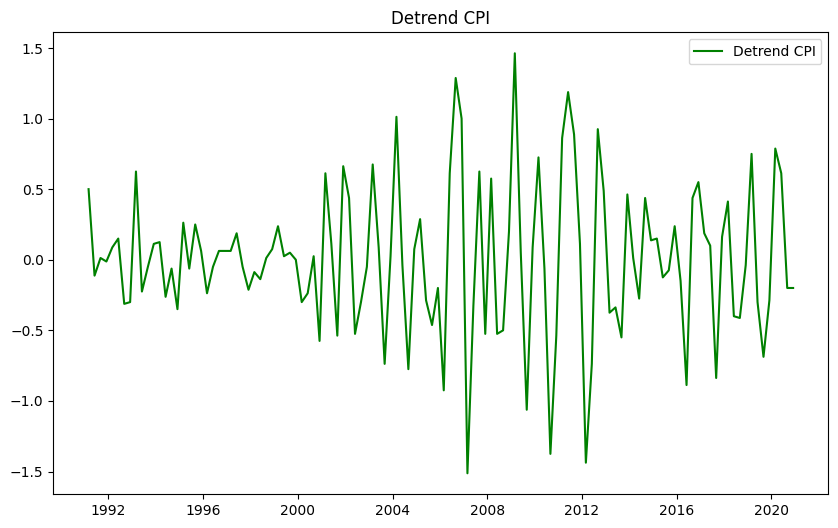

In [105]:
# Detrending the training set
detrend = train_data_decomposition - trend_estimate

# Visualize the detrended training data
plt.figure(figsize=(10, 6))
plt.plot(train_data_decomposition.index, detrend, label='Detrend CPI', color='green')
plt.legend()
plt.title('Detrend CPI')
plt.savefig(' .png', dpi=300, bbox_inches='tight')
plt.show()

**Step3: seasonal indices**

First average value per quarter

In [106]:
detrend

,CPI
Quarter,
1990-09-01,NaN
1990-12-01,NaN
1991-03-01,0.5000
1991-06-01,-0.1125
1991-09-01,0.0125
1991-12-01,-0.0125
1992-03-01,0.0875
1992-06-01,0.1500
1992-09-01,-0.3125


In [107]:
detrend.shape

(124, 1)

In [108]:
detrend_values = np.nan_to_num(detrend)
train_data_detrended = detrend_values[2:-2]
train_data_detrended

array([[ 0.5   ],
       [-0.1125],
       [ 0.0125],
       [-0.0125],
       [ 0.0875],
       [ 0.15  ],
       [-0.3125],
       [-0.3   ],
       [ 0.625 ],
       [-0.225 ],
       [-0.05  ],
       [ 0.1125],
       [ 0.125 ],
       [-0.2625],
       [-0.0625],
       [-0.35  ],
       [ 0.2625],
       [-0.0625],
       [ 0.25  ],
       [ 0.0625],
       [-0.2375],
       [-0.05  ],
       [ 0.0625],
       [ 0.0625],
       [ 0.0625],
       [ 0.1875],
       [-0.05  ],
       [-0.2125],
       [-0.0875],
       [-0.1375],
       [ 0.0125],
       [ 0.075 ],
       [ 0.2375],
       [ 0.025 ],
       [ 0.05  ],
       [ 0.    ],
       [-0.3   ],
       [-0.2375],
       [ 0.025 ],
       [-0.575 ],
       [ 0.6125],
       [ 0.1125],
       [-0.5375],
       [ 0.6625],
       [ 0.4375],
       [-0.525 ],
       [-0.3   ],
       [-0.05  ],
       [ 0.675 ],
       [ 0.0875],
       [-0.7375],
       [ 0.025 ],
       [ 1.0125],
       [-0.0375],
       [-0.775 ],
       [ 0

In [109]:
len(train_data_detrended)

120

In [110]:
num_years = 30

# Use np.reshape to transform the data into the shape of (num_years, 4)
reshaped_detrended = np.reshape(train_data_detrended, (num_years, 4))

reshaped_detrended

array([[ 0.5   , -0.1125,  0.0125, -0.0125],
       [ 0.0875,  0.15  , -0.3125, -0.3   ],
       [ 0.625 , -0.225 , -0.05  ,  0.1125],
       [ 0.125 , -0.2625, -0.0625, -0.35  ],
       [ 0.2625, -0.0625,  0.25  ,  0.0625],
       [-0.2375, -0.05  ,  0.0625,  0.0625],
       [ 0.0625,  0.1875, -0.05  , -0.2125],
       [-0.0875, -0.1375,  0.0125,  0.075 ],
       [ 0.2375,  0.025 ,  0.05  ,  0.    ],
       [-0.3   , -0.2375,  0.025 , -0.575 ],
       [ 0.6125,  0.1125, -0.5375,  0.6625],
       [ 0.4375, -0.525 , -0.3   , -0.05  ],
       [ 0.675 ,  0.0875, -0.7375,  0.025 ],
       [ 1.0125, -0.0375, -0.775 ,  0.075 ],
       [ 0.2875, -0.2875, -0.4625, -0.2   ],
       [-0.925 ,  0.6125,  1.2875,  1.    ],
       [-1.5125, -0.325 ,  0.625 , -0.525 ],
       [ 0.575 , -0.525 , -0.5   ,  0.2   ],
       [ 1.4625,  0.05  , -1.0625,  0.0875],
       [ 0.725 , -0.0625, -1.375 , -0.5375],
       [ 0.8625,  1.1875,  0.8875,  0.1125],
       [-1.4375, -0.7375,  0.925 ,  0.4875],
       [-0

In [111]:
# Calculate the mean of each column (each quarter)
seasonal_means = np.mean(reshaped_detrended, axis=0)  #axis=0 means calculating the mean along the rows

print("Seasonal Averages:")
print(seasonal_means)

Seasonal Averages:
[ 0.19416667 -0.09291667 -0.1325      0.04083333]


In [112]:
# Convert to DataFrame
seasonal_means_df = pd.DataFrame(seasonal_means, columns=['Mean'])
seasonal_means_df

,Mean
0,0.194167
1,-0.092917
2,-0.132500
3,0.040833


Second normalization

In [113]:
# Calculate the seasonal index (mean). If seasonal_index is not equal to 0, normalization is required
seasonal_index = seasonal_means.mean()
print("Seasonal Index (Overall Average):", seasonal_index)

Seasonal Index (Overall Average): 0.0023958333333329897


In [114]:
# Normalization
seasonal_means_normalized = seasonal_means - seasonal_index

print("Normalized Seasonal Indices:")
print(seasonal_means_normalized)

Normalized Seasonal Indices:
[ 0.19177083 -0.0953125  -0.13489583  0.0384375 ]


In [115]:
seasonal_means_normalized_df = pd.DataFrame(seasonal_means_normalized, columns=['Normalized'])
seasonal_means_normalized_df

,Normalized
0,0.191771
1,-0.095313
2,-0.134896
3,0.038438


Third tile

In [116]:
# Repeated normalization of seasonal means using np.tile
seasonal_index_expanded = np.tile(seasonal_means_normalized, 32)

# Remove the two data points before and after the data to ensure that the length is consistent with the original data
seasonal_index_expanded = seasonal_index_expanded[2:-2]  

seasonal_index_expanded.shape

(124,)

In [117]:
seasonal_index_expanded_df = pd.DataFrame(seasonal_index_expanded, columns=['Seasonal_Index'])
seasonal_index_expanded_df

,Seasonal_Index
0,-0.134896
1,0.038438
2,0.191771
3,-0.095313
4,-0.134896
5,0.038438
6,0.191771
7,-0.095313
8,-0.134896
9,0.038438


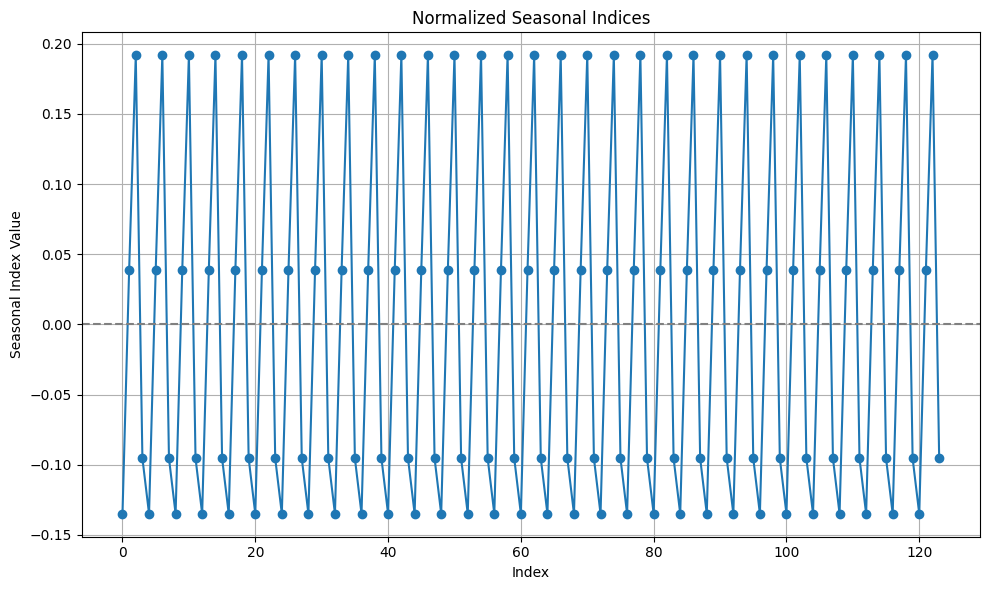

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(seasonal_index_expanded, marker='o', linestyle='-')
plt.title('Normalized Seasonal Indices')
plt.xlabel('Index')
plt.ylabel('Seasonal Index Value')
plt.grid()
plt.axhline(0, color='gray', linestyle='--')  
plt.tight_layout()
plt.savefig(' .png', dpi=300, bbox_inches='tight')
plt.show()

As can be seen from the figure, the seasonal index shows obvious cyclical changes, and its fluctuation range is mainly concentrated between -0.1 and 0.15, which indicates that the data has stable seasonal characteristics.

**Step4: de-seasonal**

In [119]:
# De-seasonal
CPI_deseasonalized = train_data_decomposition['CPI'] - seasonal_index_expanded

CPI_deseasonalized

Quarter
1990-09-01     51.434896
1990-12-01     51.761562
1991-03-01     52.708229
1991-06-01     52.795313
1991-09-01     53.234896
1991-12-01     53.261562
1992-03-01     53.408229
1992-06-01     53.895312
1992-09-01     53.734896
1992-12-01     53.861562
1993-03-01     54.908229
1993-06-01     54.695312
1993-09-01     55.134896
1993-12-01     55.261562
1994-03-01     55.308229
1994-06-01     55.395312
1994-09-01     55.934896
1994-12-01     55.961562
1995-03-01     57.008229
1995-06-01     57.595312
1995-09-01     58.434896
1995-12-01     58.461562
1996-03-01     58.408229
1996-06-01     59.295313
1996-09-01     59.934896
1996-12-01     60.261562
1997-03-01     60.508229
1997-06-01     61.195312
1997-09-01     61.234896
1997-12-01     61.161563
1998-03-01     61.508229
1998-06-01     62.295313
1998-09-01     63.134896
1998-12-01     63.661563
1999-03-01     64.208229
1999-06-01     64.695312
1999-09-01     65.034896
1999-12-01     65.061562
2000-03-01     65.008229
2000-06-01     65

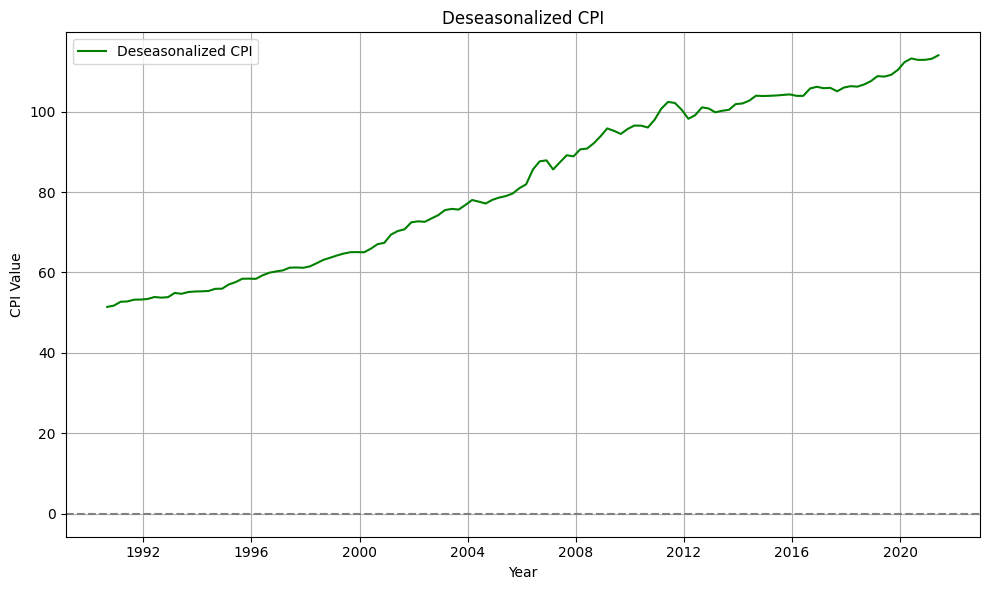

In [120]:
# Visualizing Deseasonalized CPI
plt.figure(figsize=(10, 6))
plt.plot(train_data_decomposition.index, CPI_deseasonalized, label='Deseasonalized CPI', color='green')
plt.title('Deseasonalized CPI')
plt.xlabel('Year')
plt.ylabel('CPI Value')
plt.axhline(0, color='gray', linestyle='--')  
plt.grid()
plt.tight_layout()
plt.legend()
plt.savefig(' .png', dpi=300, bbox_inches='tight')
plt.show()


After reducing the seasonal disturbances the changes in CPI are more stable and the CPI values are generally on an upward trend. In addition, the fluctuations between 2008 and 2012 may reflect the impact of some non-seasonal economic factors and events during this period.


**Step5: obtain trend component**

In [121]:
window_size = 4  

# Calculating the trend component
trend_component = CPI_deseasonalized.rolling(window=window_size, center=True).mean().rolling(2, center=True).mean().shift(-1)
trend_component = trend_component[2:-2]

print("Trend Component:")
print(trend_component.head())

Trend Component:
Quarter
1991-03-01    52.4000
1991-06-01    52.8125
1991-09-01    53.0875
1991-12-01    53.3125
1992-03-01    53.5125
Name: CPI, dtype: float64


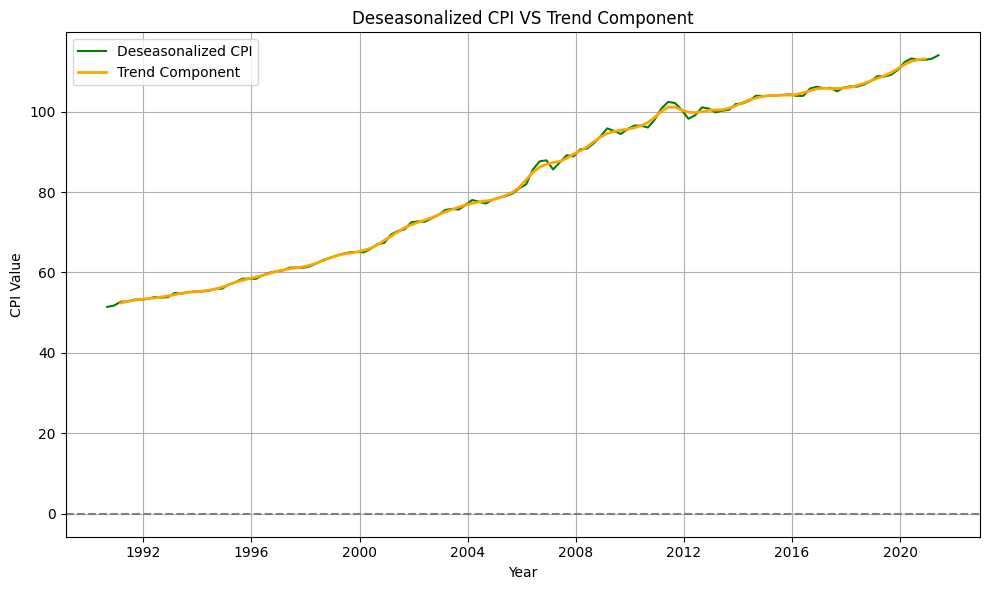

In [122]:
# Visualizing Deseasonalized CPI and Trend Components
plt.figure(figsize=(10, 6))
plt.plot(train_data_decomposition.index, CPI_deseasonalized, label='Deseasonalized CPI', color='green')
plt.plot(train_data_decomposition.index[2:-2], trend_component, label='Trend Component', color='orange', linewidth=2)
plt.title('Deseasonalized CPI VS Trend Component')
plt.xlabel('Year')
plt.ylabel('CPI Value')
plt.axhline(0, color='gray', linestyle='--') 
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(' .png', dpi=300, bbox_inches='tight')
plt.show()

The orange curve represents the trend component, which is obtained by moving average and is used to capture long-term trends. The trend component also shows an upward trend overall, but is smoother than the deseasonalized CPI curve.

**Step6: Forecasting**

In [123]:
len(trend_component)

120

In [124]:
trend_component_list = trend_component.to_list()

In [125]:
# Predict the quarterly CPI index from March 2023 to June 2024, so it is 6-step. 
# Since we need 6 predictions, plus the 2 NaNs at the end, there are a total of 8 predictions
for i in range(8):
    # Calculate the mean of the last 4 values and add them to a list
    next_value = np.mean(trend_component_list[-4:])
    trend_component_list.append(next_value)

In [126]:
len(trend_component_list)

128

In [127]:
# Trend forecasting, 6-step
trend_forecasting = trend_component_list[-6:]
trend_forecasting

[112.82734375000001,
 112.8091796875,
 112.736474609375,
 112.78309326171876,
 112.78902282714844,
 112.77944259643556]

In [128]:
# Seasonal forecasting, 6-step
seasonal_forecasting = seasonal_index_expanded[:6]
seasonal_forecasting

array([-0.13489583,  0.0384375 ,  0.19177083, -0.0953125 , -0.13489583,
        0.0384375 ])

In [129]:
# additive decomposition = trend + seasonal
forecasting = trend_forecasting + seasonal_forecasting
print("Final Forecasting (Additive Decomposition):")
print(forecasting)

Final Forecasting (Additive Decomposition):
[112.69244792 112.84761719 112.92824544 112.68778076 112.65412699
 112.8178801 ]


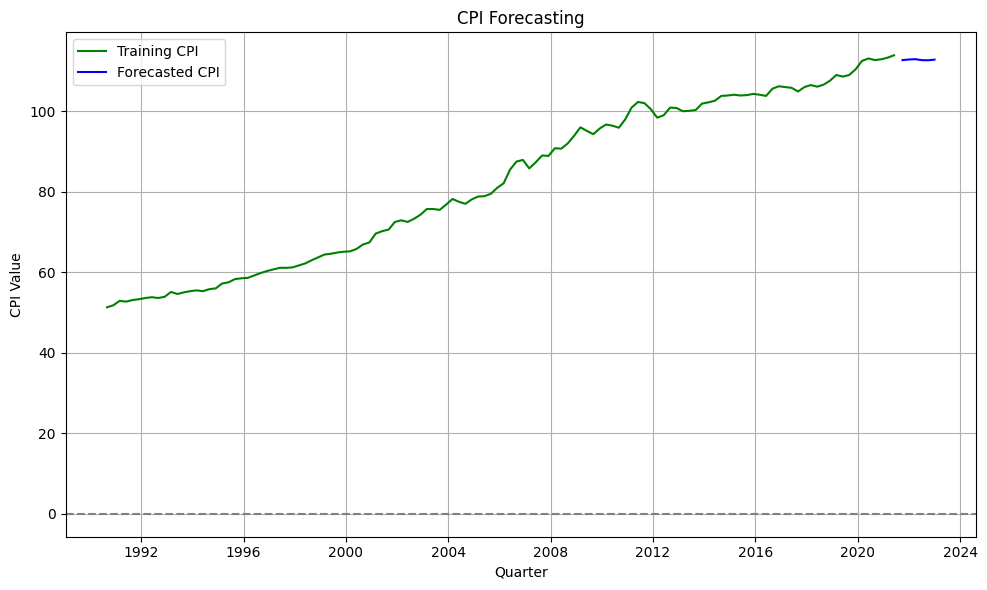

In [130]:
# Visualizing the training set and predictions
plt.figure(figsize=(10, 6))
plt.plot(train_data_decomposition.index, train_data_decomposition['CPI'], label='Training CPI', color='green')
forecast_start_date = pd.date_range(start='2021-09-01', periods=len(forecasting), freq='Q')
plt.plot(forecast_start_date, forecasting, label='Forecasted CPI', color='blue')
plt.title('CPI Forecasting')
plt.xlabel('Quarter')
plt.ylabel('CPI Value')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**Step7: MSE**

In [131]:
from sklearn.metrics import mean_squared_error

mse_decomposition = mean_squared_error(test_data['CPI'], forecasting)
print(f"MSE of decomposition is {mse_decomposition:.4f}")

MSE of decomposition is 66.8346


### Residual diagnostics

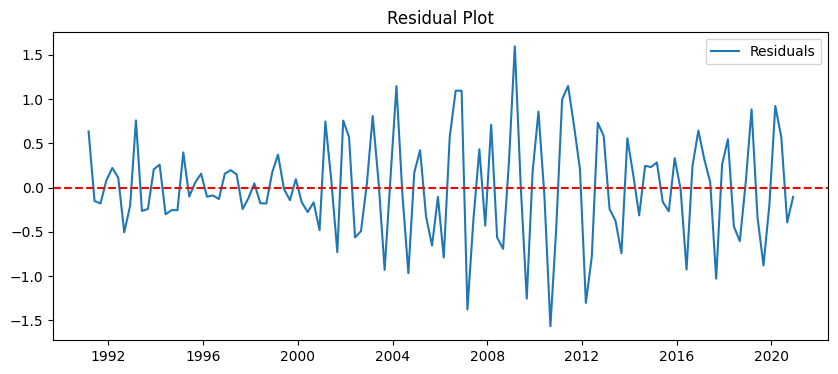

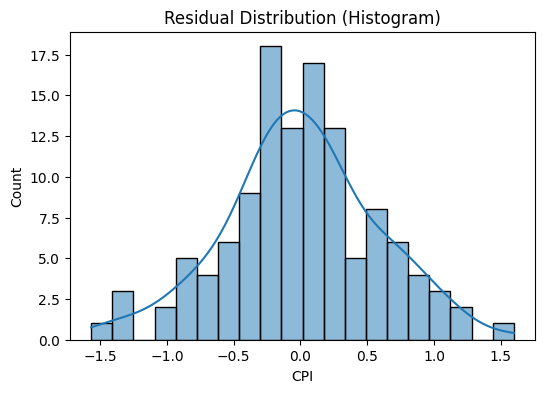

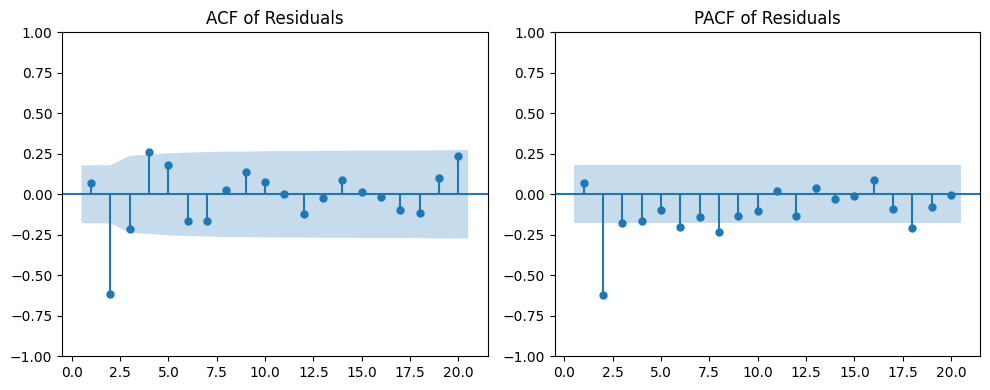

In [132]:
fitted_values = trend_component + seasonal_index_expanded[:len(trend_component)]
decomposition_residuals = train_data['CPI'] - fitted_values
plot_residual(decomposition_residuals.dropna())

## SARIMA

Firstly, we have the original dataset and cash_rate dataset, which includes historical and future cash rate data. The SARIMA model is particularly suitable for dealing with such data that is affected by both time trends and seasonal component. Through EDA visualization, it is observed that the CPI value gradually increases with time, showing an obvious time trend. In addition, CPI data is based on quarter, so the model needs to take into account seasonal factors, therefore it is reasonable to choose SARIMAX as the basis for building the forecast model.

The base_sarima_model functions include the steps to build the basic model of SARIMA, extract the CPI data in the training set firstly, and set the order parameter =(1,1,1). The three numbers respectively represent that the model constantly uses the data of the previous quarter as the basis for the subsequent prediction data, and only performs one difference operation. The unstable time series is converted to stationary data, and the previous data prediction error is used to improve the current forecast. At the same time, the seasonnal parameter represents the seasonal pattern in the model, and the meaning of the order parameter set before is the same. The CPI value of the previous quarter is used for forecasting and differential operation. The enforce_stationarity and enforce_invertibility parameters simultaneously mean that the model can accept non-stationary data and allow data that does not meet the reversible condition respectively. Furthermore,in the following 2 fit methods, the model is fitted for the first time and the second fine fitting for the purpose of helping the model find a better initial point. The powell method is used here to improve the convergence and fitting effect of the model, and fit the model again to achieve the better imitative effect.

In [133]:
np.random.seed(37)

In [134]:
# Prevent specific warnings from occurring
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.tsa.base.tsa_model")
warnings.simplefilter('ignore', ConvergenceWarning)
def base_sarima_model(train_data, test_data):
    # Initialize SARIMA model 
    sarima_model = SARIMAX(train_data['CPI'], 
                           order=(1, 1, 1),  # (p, d, q): Non-seasonal parameters
                           seasonal_order=(1, 1, 1, 4),  # (P, D, Q, s): Seasonal parameters (s=4 because it is quarterly data)
                           enforce_stationarity=False,  # agree non-stationary data
                           enforce_invertibility=False)  # agree non-invertible models
    # Fit the model using the 'powell' method
    sarima_result = sarima_model.fit(disp=False, method='powell')
    # Fit the model again and using the default method for final optimization
    sarima_result = sarima_model.fit(disp=False)
    # Model summary
    # print(sarima_result.summary())
    # Define the number of forecast steps
    forecast_steps = len(test_data)
    # Forecast the CPI values
    sarima_forecast = sarima_result.get_forecast(steps=forecast_steps)
    # Extract the predicted mean values
    predicted_mean = sarima_forecast.predicted_mean
    # Calculate the mean squared error (MSE)
    mse_sarima = mean_squared_error(test_data['CPI'], predicted_mean)
    return mse_sarima, predicted_mean

This plot_comparison function contains the base model, and forecasts the CPI from March 2023 to June 2024. Since our goal is to forecast CPI for the next 6 quarters,  we need to specify a reasonable time horizon, set the starting point as March 31, 2023, and forecast at a quarterly frequency. This ensures that our predictions are consistent with the task requirements. Finally, the test data and projections from the base model are printed, and the CPI projections for the six quarters from March 2023 to June 2024 are displayed.

In [135]:
def plot_comparison(train_data, test_data, predicted_mean_base, forecast_values, future_dates):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data['CPI'], label='Train Data')
    plt.plot(test_data.index, test_data['CPI'], label='Test Data')
    plt.plot(test_data.index, forecast_values, label='Predicted Data', color='red')
    plt.title('Base vs Optimized SARIMAX Model Forecast vs Actual and Future Predictions')
    plt.xlabel('Quarter')
    plt.ylabel('CPI')
    plt.legend()
#     plt.grid(True)
    plt.show()

Base Model MSE 27.0059


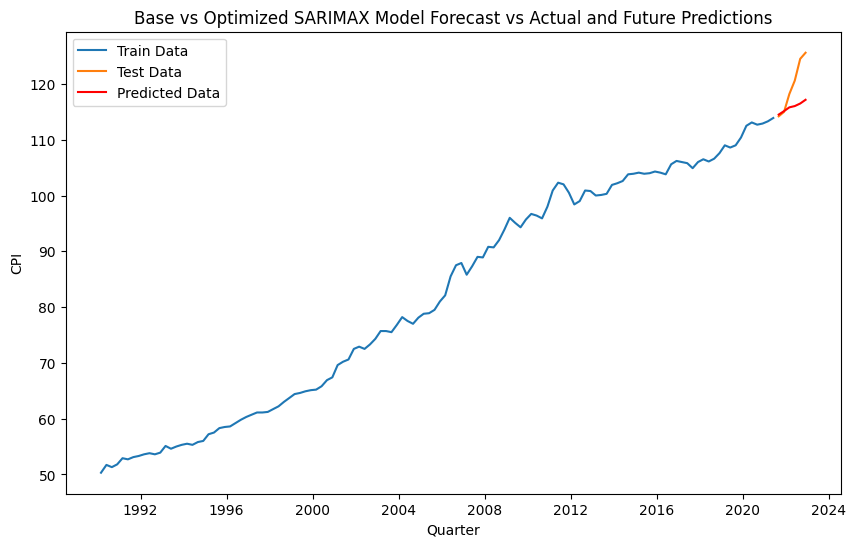

In [136]:
# Run the base SARIMA model
mse_base, predicted_mean_base = base_sarima_model(train_data, test_data)
# Print the MSE results
print("Base Model MSE", round(mse_base, 4))
# Forecast the future CPI values for the next 6 quarters
forecast_steps = 6
sarima_model= SARIMAX(train_data['CPI'], 
                                 order=(1, 1, 1),  
                                 seasonal_order=(1, 1, 1, 4), 
                                 enforce_stationarity=False, 
                                 enforce_invertibility=False).fit(disp=False)
sarima_future_forecast =sarima_model.get_forecast(steps=forecast_steps)
# Extract the forecasted CPI values
forecast_values = sarima_future_forecast.predicted_mean
# Generate future dates
future_dates = pd.date_range(start="2023-03-31", periods=forecast_steps, freq='Q')
forecast_values.index = future_dates
plot_comparison(train_data, test_data, predicted_mean_base, forecast_values, future_dates)

### Residual diagnostics

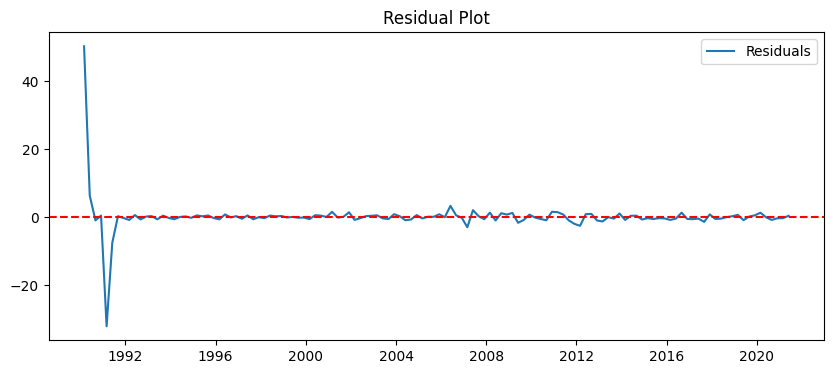

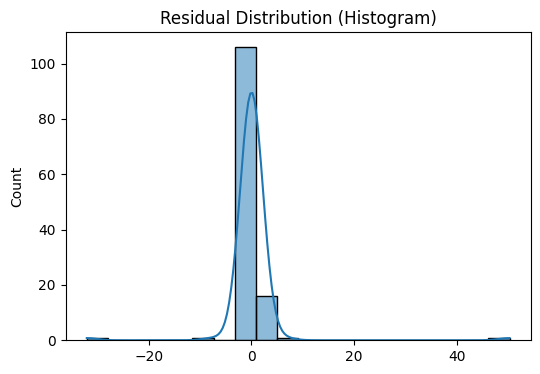

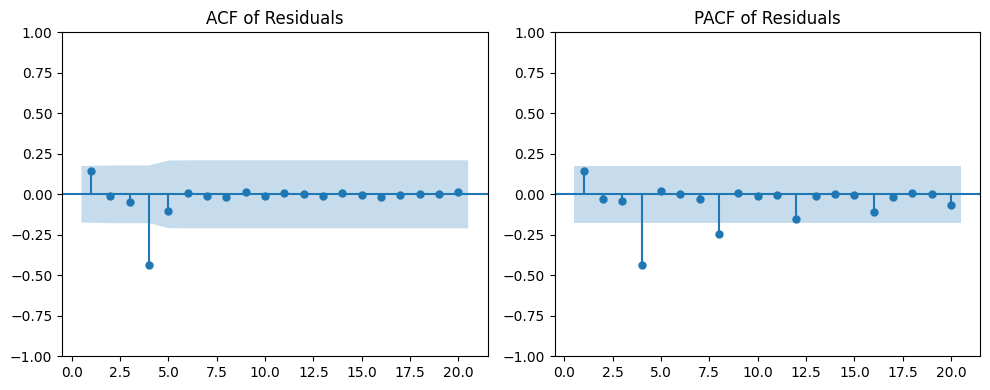

In [137]:
fitted_values = sarima_model.fittedvalues
residuals = train_data['CPI'] - fitted_values
plot_residual(residuals)

##  Holt-Winter

In [138]:
np.random.seed(37)

### train for model selection

predictions:
 2021-09-01    114.338712
2021-12-01    115.012895
2022-03-01    115.670975
2022-06-01    115.942847
2022-09-01    116.381559
2022-12-01    117.055742
Freq: QS-DEC, dtype: float64

Mean Squared Error (MSE): 27.8363


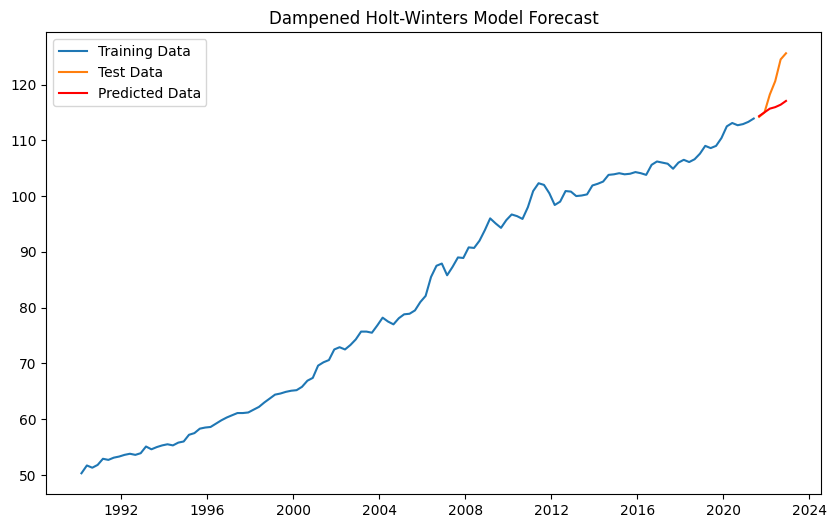

In [139]:
# train Dampened Holt-Winters model
damped_holtwinter_model = ExponentialSmoothing(train_data,
                             trend='add',  
                             seasonal='add',  
                             damped_trend=False)  
fit_model = damped_holtwinter_model.fit()

# predictions
predictions = fit_model.forecast(steps=6)
print("predictions:\n",predictions)

# calculate MSE
mse = mean_squared_error(test_data, predictions)
print(f'\nMean Squared Error (MSE): {mse.round(4)}')

# visualization
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(test_data.index, predictions, label='Predicted Data', color='red')
plt.legend()
plt.title('Dampened Holt-Winters Model Forecast')
plt.show()

In [140]:
fit_model.summary()

Dep. Variable:,CPI,No. Observations:,126
Model:,ExponentialSmoothing,SSE,92.253
Optimized:,True,AIC,-23.280
Trend:,Additive,BIC,-0.590
Seasonal:,Additive,AICC,-21.367
Seasonal Periods:,4,Date:,"Wed, 30 Oct 2024"
Box-Cox:,False,Time:,15:43:00
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,2.1121e-09,beta,True


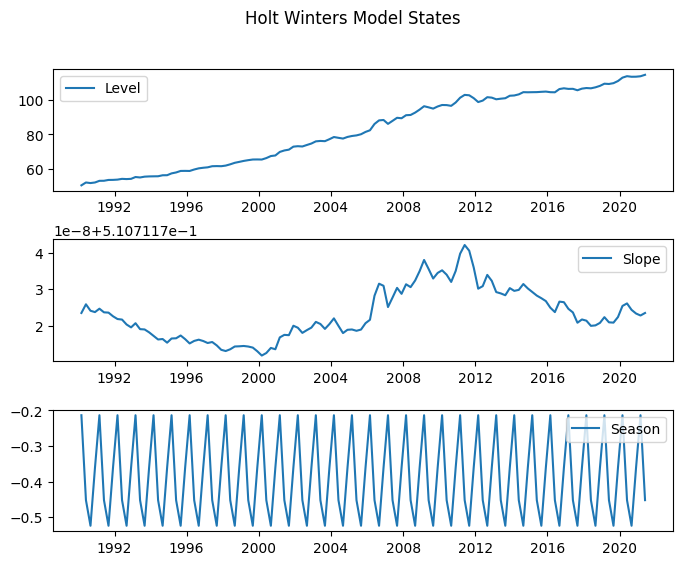

In [141]:
# calculate state
level = fit_model.level
slope = fit_model.trend
season = fit_model.season

# visualization
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].plot(level, label='Level')
axes[0].legend()
axes[1].plot(slope, label='Slope')
axes[1].legend()
axes[2].plot(season, label='Season')
axes[2].legend()
plt.suptitle("Holt Winters Model States")
plt.subplots_adjust(hspace=0.4)  
plt.show();

### Residual diagnostics

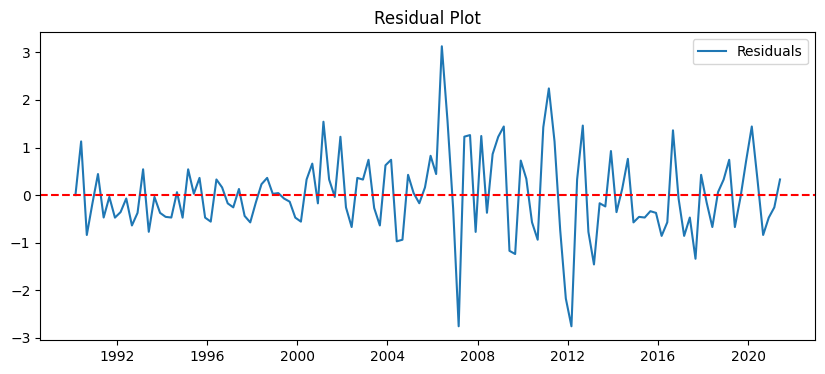

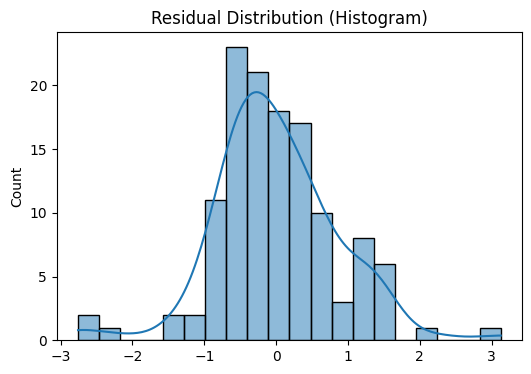

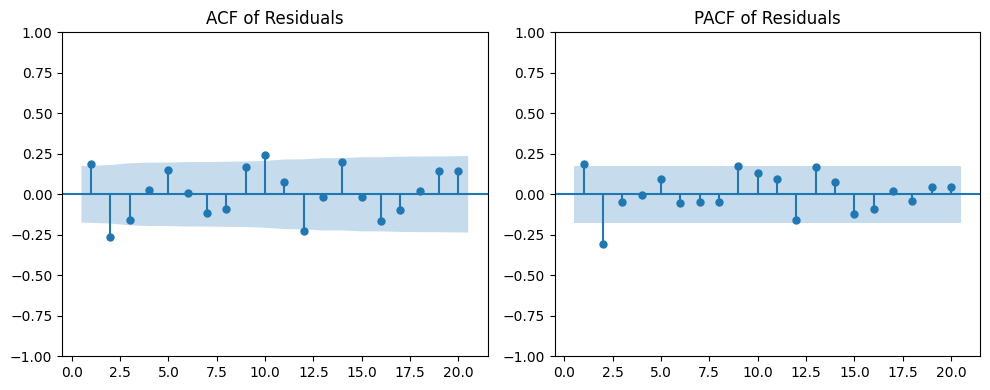

In [142]:
residuals = fit_model.resid
plot_residual(residuals)

### final predictions

AIC Value: -2.477539612154292
2023-03-01    126.337501
2023-06-01    126.673864
2023-09-01    127.213258
2023-12-01    127.904166
2024-03-01    128.641667
2024-06-01    128.978031
Freq: QS-DEC, dtype: float64


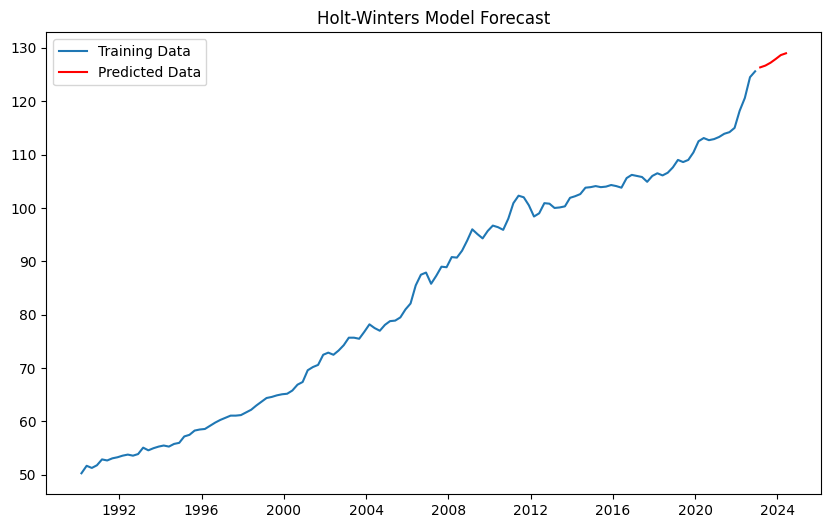

In [143]:
np.random.seed(37)
# train Dampened Holt-Winters model on the complete dataset
damped_holtwinter_model = ExponentialSmoothing(data_CPI,
                             trend='add',  
                             seasonal='add', 
                             damped_trend=False)  
fit_model = damped_holtwinter_model.fit()
# calculate AIC
aic_value = fit_model.aic
print(f"AIC Value: {aic_value}")

# predictions and save to csv
predictions = fit_model.forecast(steps=6)
predicted_df = pd.DataFrame({
    'Quarter': predictions.index,  
    'CPI': predictions.values  
})
predicted_df.to_csv('Forecast_Holtwinter.csv', index=False)
print(predictions)

# visualization
plt.figure(figsize=(10, 6))
plt.plot(data_CPI, label='Training Data')
# plt.plot(test_data, label='Test Data')
plt.plot(predictions.index, predictions, label='Predicted Data', color='red')
plt.legend()
plt.title('Holt-Winters Model Forecast')
plt.show()

# Final Model

In [144]:
np.random.seed(37)

In [145]:
# Prevent specific warnings from occurring
def final_sarima_model(data, forecast_steps=6):
    # Initialize SARIMAX model with the entire dataset
    sarima_model = SARIMAX(data, 
                           order=(1, 1, 1),  # (p, d, q): Non-seasonal parameters
                           seasonal_order=(1, 1, 1, 4),  # (P, D, Q, s): Seasonal parameters (s=4 because it is quarterly data)
                           enforce_stationarity=False,  # allow non-stationary data
                           enforce_invertibility=False)  # allow non-invertible models
    # Fit the model 
    sarima_result = sarima_model.fit(disp=False, method='powell')
    # Fit the model again using the default method for final optimization
    sarima_result = sarima_model.fit(disp=False)
    # Forecast the CPI values 
    sarima_forecast = sarima_result.get_forecast(steps=forecast_steps)
    # Extract the predicted mean values
    predicted_mean = sarima_forecast.predicted_mean
    # Use 'QS-MAR' to generate start-of-quarter dates beginning in March
    future_dates = pd.date_range(start="2023-03-01", periods=forecast_steps, freq='QS-MAR')
    predicted_mean.index = future_dates
    return predicted_mean

# Define the number of quarters to forecast
forecast_steps = 6
data_CPI = pd.read_csv('CPI_train.csv')
predicted_mean = final_sarima_model(data_CPI[['CPI']], forecast_steps)

# Save results to a CSV file
df = pd.DataFrame({'Quarter': predicted_mean.index.strftime('%Y-%m'), 'CPI': predicted_mean.values}) 
df.to_csv('Group_37_forecast.csv', index=False)

# Print forecasted CPI values
print(f"Forecasted CPI values for the next {forecast_steps} quarters:\n{predicted_mean}")

Forecasted CPI values for the next 6 quarters:
2023-03-01    125.934138
2023-06-01    126.291519
2023-09-01    126.827738
2023-12-01    127.519143
2024-03-01    128.244335
2024-06-01    128.541952
Freq: QS-MAR, Name: predicted_mean, dtype: float64


# Test Error

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error

cpi_test = pd.read_csv('CPI_test.csv')

predicted_cpi = pd.read_csv('Group_37_forecast.csv')
test_error = mean_squared_error(cpi_test['CPI'], predicted_cpi['CPI'])

print(test_error)